In [948]:
import numpy as np
import skfuzzy as fuzz
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skfuzzy import control as ctrl
import warnings
warnings.filterwarnings("ignore")

In [949]:
df = pd.read_excel('dataset.xlsx', nrows=279)
df["SESSO"].replace({'M': 0., 'F': 1.}, inplace=True)
df["TARGET"].replace({2.0: 1.}, inplace=True)
df = df.drop(columns=["AGE", "PCR", "ALP", "Piastrine", "Neutrofili", "WBC", "Monociti", "GGT", "AST", "SESSO"])
# df = df.drop(columns=["AGE", "ALP", "Piastrine", "Neutrofili", "GGT", "SESSO"])
for key in df.keys():
    df[key] = pd.to_numeric(df[key].astype(str).str.replace(",", ""), errors='coerce')
correlations = np.array(df.corrwith(df['TARGET'], method="kendall"))[:-1]
print(f"Correlations with TARGET:\n", df.corrwith(df['TARGET'], method="kendall"))
beta = 0.2
chosen_corrs = correlations > beta
X = df.drop(columns='TARGET').to_numpy(dtype=np.float64)
# X = df[['Eosinofili', 'AST', 'LDH', 'PCR', 'Monociti', 'Linfociti']].to_numpy(dtype=np.float64)
X = X[:, chosen_corrs]
y = df['TARGET'].to_numpy(dtype=np.float64)

Correlations with TARGET:
 Linfociti    -0.213555
Eosinofili   -0.215767
Basofili     -0.171577
ALT           0.224363
LDH           0.363080
TARGET        1.000000
dtype: float64


In [950]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=300, random_state=0)
imp.fit(df)
df = np.round(imp.transform(df), 1)

In [951]:
df_train, df_test = train_test_split(df, stratify=y, test_size=0.1)
df_train = np.array(df_train)
df_test = np.array(df_test)

In [952]:
from pyit2fls import IT2FS, T1Mamdani, IT2FS_plot, singleton_mf, trapezoid_mf, rtri_mf, ltri_mf, tri_mf
import matplotlib.pyplot as plt
import math
from functools import reduce

class Control:
    def __init__(self, domain, name):
        self.name = name
        self.domain = domain
        self.terms = []

    def add_fs(self, name, mf, params):
        if(len(mf) == 1):
            t2fs = IT2FS(self.domain, mf[0], params[0])
        else:
            t2fs = IT2FS(self.domain, mf[0], params[0], mf[1], params[1])
        setattr(self, name, [mf, params, t2fs])
        self.terms.append((name, mf, params, t2fs))

    def view(self):
        IT2FS_plot(*[term[3] for term in self.terms], legends=[term[0] for term in self.terms])
        
    def get_term(self, x):
        y_s = {}
        for term in self.terms:
            min_fs = 9999
            for mf, params in zip(term[1], term[2]):
                min_fs = min(mf(x, params), min_fs)
            y_s[term[0]] = min_fs

        return max(y_s, key=y_s.get)

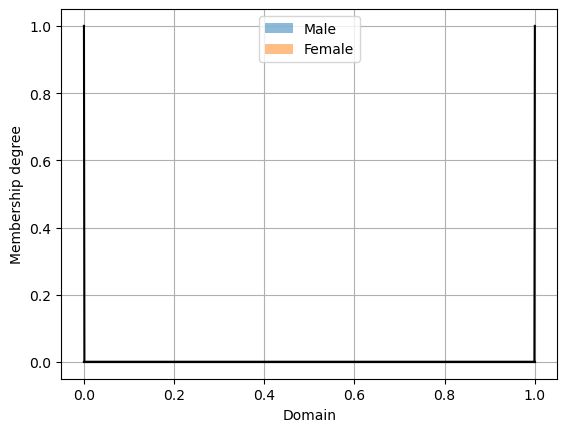

In [953]:
SESSO = Control(np.linspace(0., 1., 1001), 'SESSO')
SESSO.add_fs('Male', [singleton_mf], [[0, 1]])
SESSO.add_fs('Female', [singleton_mf], [[1, 1]])
SESSO.view()

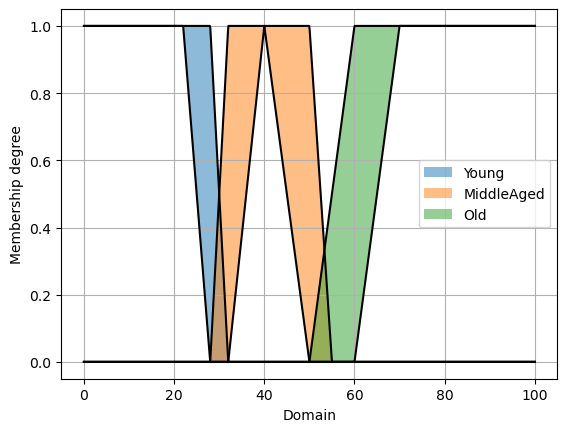

In [954]:
AGE = Control(np.linspace(0, 100, 1000), 'AGE')
AGE.add_fs('Young', [rtri_mf, rtri_mf], [[32, 28, 1], [28, 22, 1]])
AGE.add_fs('MiddleAged', [trapezoid_mf, tri_mf], [[28, 32, 50, 55, 1], [32, 40, 50, 1]])
AGE.add_fs('Old', [ltri_mf, ltri_mf], [[50, 60, 1], [60, 70, 1]])
AGE.view()

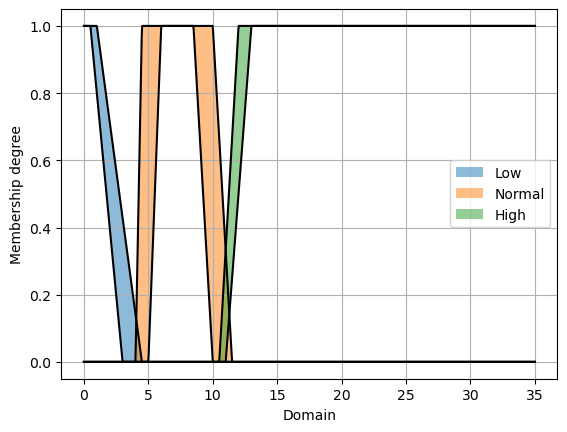

In [955]:
WBC = Control(np.linspace(0, 35, 1000), 'WBC')
WBC.add_fs('Low', [rtri_mf, rtri_mf], [[4.5, 1, 1], [3, 0.5, 1]])
WBC.add_fs('Normal', [trapezoid_mf, trapezoid_mf], [[4, 4.5, 10, 11.5, 1], [5, 6, 8.5, 10, 1]])
WBC.add_fs('High', [ltri_mf, ltri_mf], [[10.5, 12, 1], [11, 13, 1]])
WBC.view()

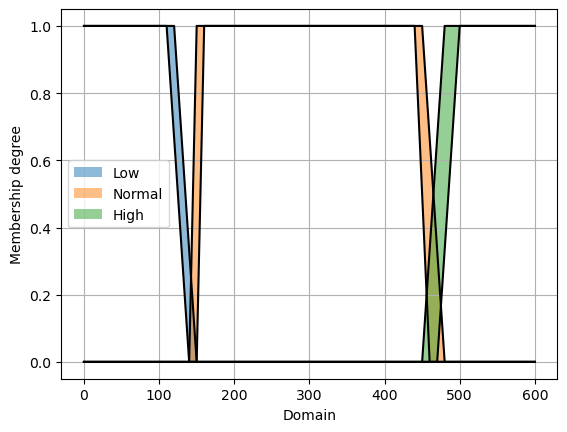

In [956]:
Piastrine = Control(np.linspace(0, 600, 601), 'Piastrine')
Piastrine.add_fs('Low', [rtri_mf, rtri_mf], [[150, 120, 1], [140, 110, 1]])
Piastrine.add_fs('Normal', [trapezoid_mf, trapezoid_mf], [[140, 150, 450, 480, 1], [150, 160, 440, 460, 1]])
Piastrine.add_fs('High', [ltri_mf, ltri_mf], [[450, 480, 1], [470, 500, 1]])
Piastrine.view()

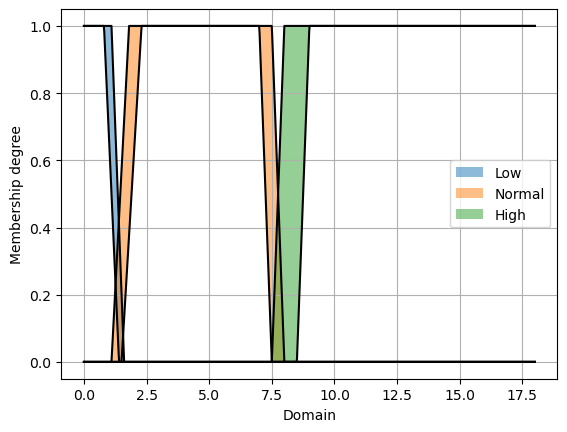

In [957]:
Neutrofili = Control(np.linspace(0, 18, 1000), 'Neutrofili')
Neutrofili.add_fs('Low', [rtri_mf, rtri_mf], [[1.6, 1.1, 1], [1.4, 0.8, 1]])
Neutrofili.add_fs('Normal', [trapezoid_mf, trapezoid_mf], [[1.1, 1.8, 7.5, 8, 1], [1.5, 2.3, 7, 7.5, 1]])
Neutrofili.add_fs('High', [ltri_mf, ltri_mf], [[7.5, 8, 1], [8.5, 9, 1]])
Neutrofili.view()

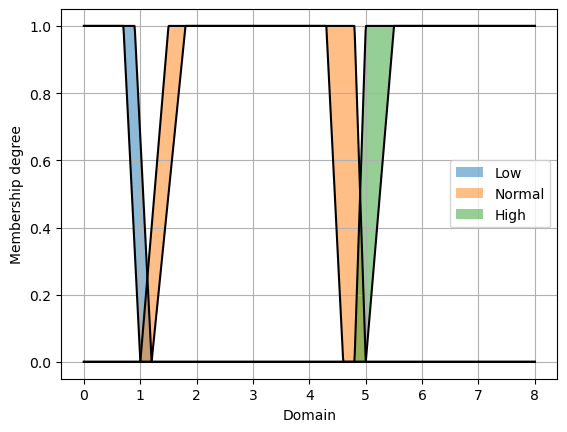

In [958]:

Linfociti = Control(np.linspace(0, 8, 1000), 'Linfociti')
Linfociti.add_fs('Low', [rtri_mf, rtri_mf], [[1.2, 0.9, 1], [1, 0.7, 1]])
Linfociti.add_fs('Normal', [trapezoid_mf, trapezoid_mf], [[1, 1.5, 4.8, 5, 1], [1.2, 1.8, 4.3, 4.6, 1]])
Linfociti.add_fs('High', [ltri_mf, ltri_mf], [[4.8, 5, 1], [5, 5.5, 1]])
Linfociti.view()

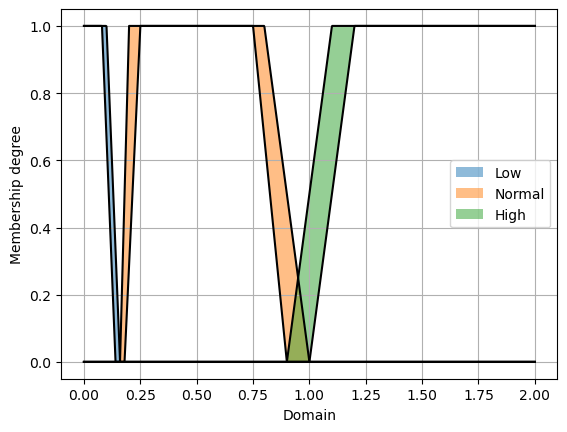

In [959]:
Monociti = Control(np.linspace(0, 2, 1000), 'Monociti')
Monociti.add_fs('Low', [rtri_mf, rtri_mf], [[0.16, 0.1, 1], [0.14, 0.08, 1]])
Monociti.add_fs('Normal', [trapezoid_mf, trapezoid_mf], [[0.16, 0.2, 0.8, 1, 1], [0.18, 0.25, 0.75, 0.9, 1]])
Monociti.add_fs('High', [ltri_mf, ltri_mf], [[0.9, 1.1, 1], [1, 1.2, 1]])
Monociti.view()

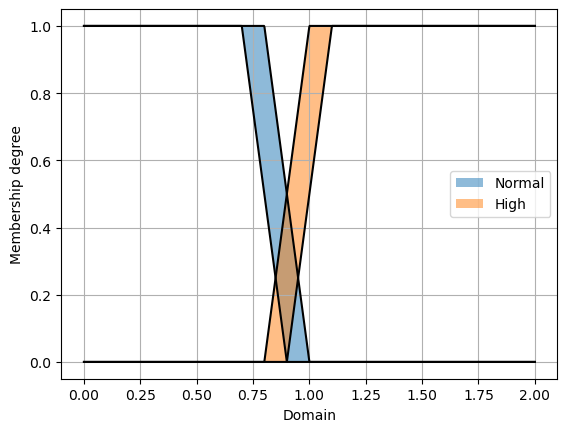

In [960]:
Eosinofili = Control(np.linspace(0, 2, 1000), 'Eosinofili')
Eosinofili.add_fs('Normal', [rtri_mf, rtri_mf], [[1, 0.8, 1], [0.9, 0.7, 1]])
Eosinofili.add_fs('High', [ltri_mf, ltri_mf], [[0.8, 1, 1], [0.9, 1.1, 1]])
Eosinofili.view()

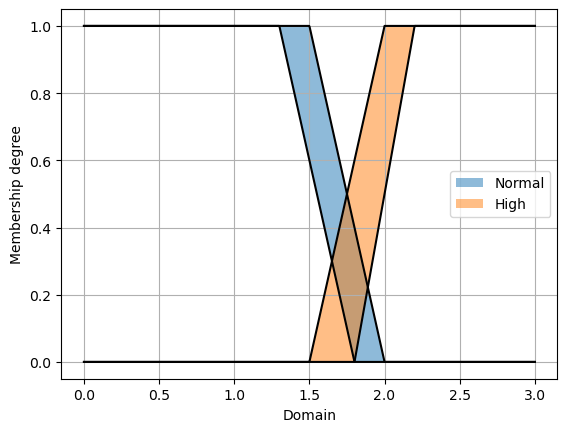

In [961]:
Basofili = Control(np.linspace(0, 3, 1000), 'Basofili')
Basofili.add_fs('Normal', [rtri_mf, rtri_mf], [[2, 1.5, 1], [1.8, 1.3, 1]])
Basofili.add_fs('High', [ltri_mf, ltri_mf], [[1.5, 2, 1], [1.8, 2.2, 1]])
Basofili.view()

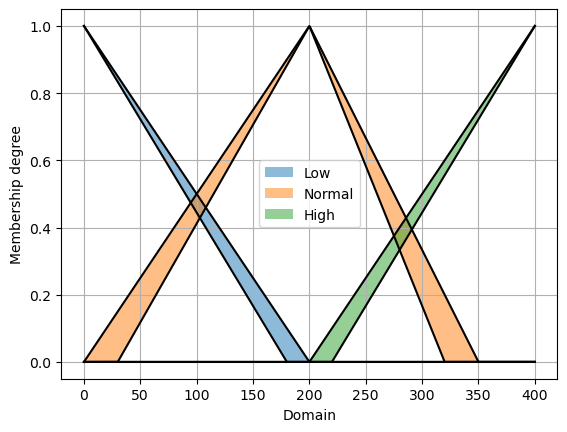

In [962]:
PCR = Control(np.linspace(0, 400, 1000), 'PCR')
PCR.add_fs('Low', [rtri_mf, rtri_mf], [[200, 0, 1], [180, 0, 1]])
PCR.add_fs('Normal', [tri_mf, tri_mf], [[0, 200, 350, 1], [30, 200, 320, 1]])
PCR.add_fs('High', [ltri_mf, ltri_mf], [[200, 400, 1], [220, 400, 1]])
PCR.view()

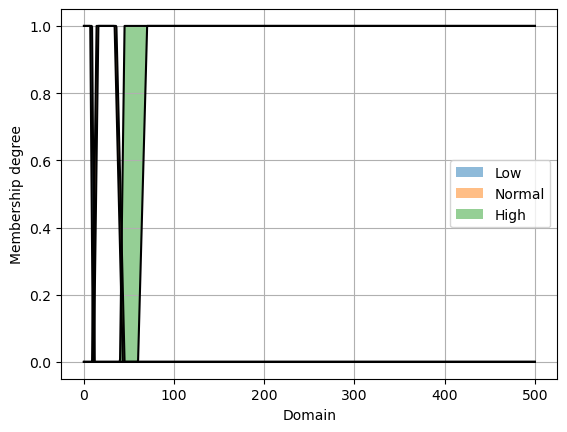

In [963]:
AST = Control(np.linspace(0, 500, 1000), 'AST')
AST.add_fs('Low', [rtri_mf, rtri_mf], [[12, 9, 1], [10, 7, 1]])
AST.add_fs('Normal', [trapezoid_mf, trapezoid_mf], [[9, 14, 36, 45, 1], [11, 16, 34, 43, 1]])
AST.add_fs('High', [ltri_mf, ltri_mf], [[40, 45, 1], [60, 70, 1]])
AST.view()

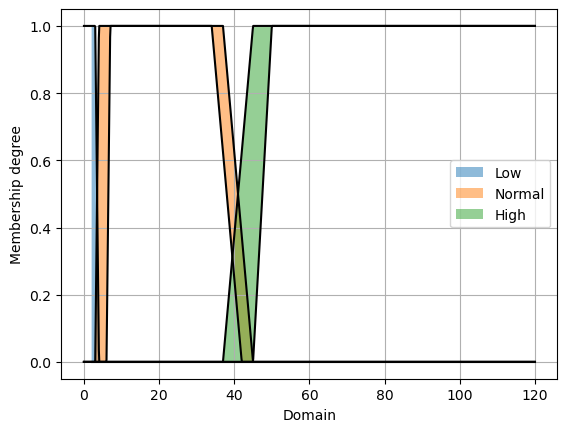

In [964]:
ALT = Control(np.linspace(0, 120, 1000), 'ALT')
ALT.add_fs('Low', [rtri_mf, rtri_mf], [[4, 3, 1], [2, 2, 1]])
ALT.add_fs('Normal', [trapezoid_mf, trapezoid_mf], [[3, 4, 37, 45, 1], [6, 7, 34, 42, 1]])
ALT.add_fs('High', [ltri_mf, ltri_mf], [[37, 45, 1], [45, 50, 1]])
ALT.view()

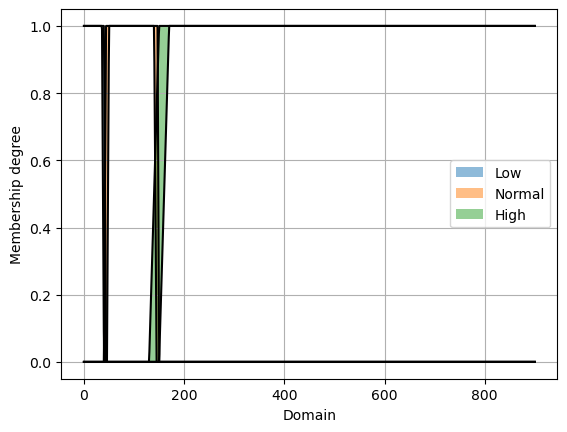

In [965]:
ALP = Control(np.linspace(0, 900, 1000), 'ALP')
ALP.add_fs('Low', [rtri_mf, rtri_mf], [[44, 40, 1], [40, 36, 1]])
ALP.add_fs('Normal', [trapezoid_mf, trapezoid_mf], [[40, 44, 147, 150, 1], [46, 50, 140, 145, 1]])
ALP.add_fs('High', [ltri_mf, ltri_mf], [[130, 150, 1], [150, 170, 1]])
ALP.view()

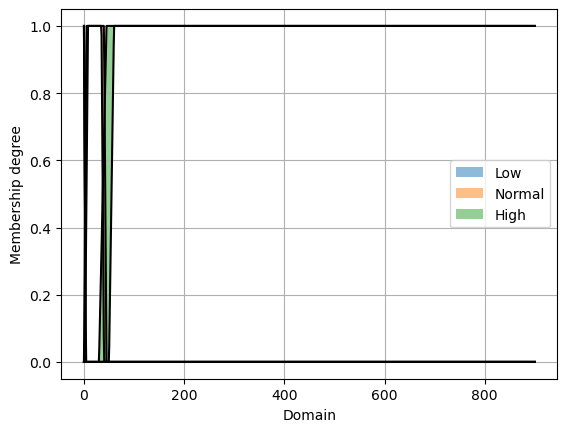

In [966]:
GGT = Control(np.linspace(0, 900, 1000), 'GGT')
GGT.add_fs('Low', [rtri_mf, rtri_mf], [[4, 0, 1], [3, 0, 1]])
GGT.add_fs('Normal', [trapezoid_mf, trapezoid_mf], [[0, 5, 40, 45, 1], [2, 8, 35, 40, 1]])
GGT.add_fs('High', [ltri_mf, ltri_mf], [[30, 45, 1], [50, 60, 1]])
GGT.view()

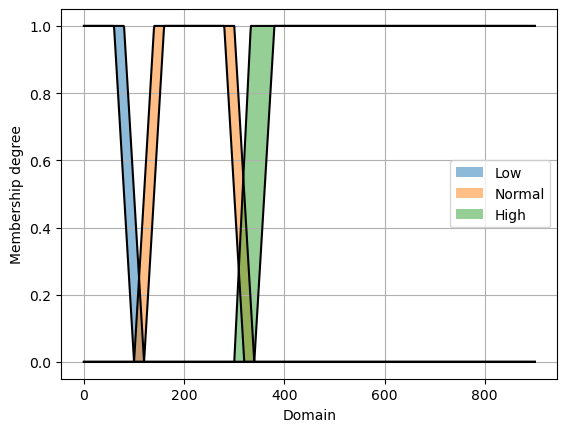

In [967]:
LDH = Control(np.linspace(0, 900, 1000), 'LDH')
LDH.add_fs('Low', [rtri_mf, rtri_mf], [[120, 80, 1], [100, 60, 1]])
LDH.add_fs('Normal', [trapezoid_mf, trapezoid_mf], [[100, 140, 300, 340, 1], [120, 160, 280, 320, 1]])
LDH.add_fs('High', [ltri_mf, ltri_mf], [[300, 333, 1], [340, 380, 1]])
LDH.view()

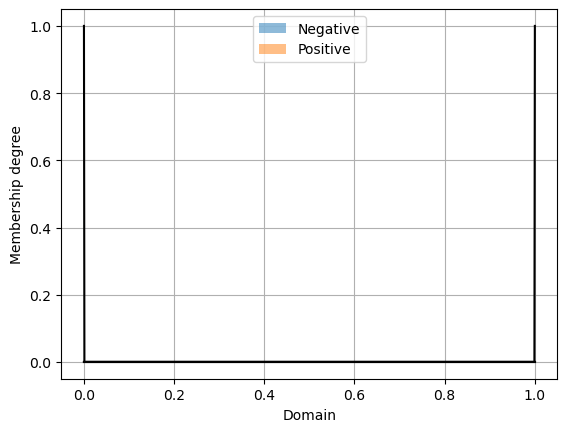

In [968]:
TARGET = Control(np.linspace(0., 1., 1001), 'TARGET')
# TARGET.add_fs('Negative', rtri_mf, [1, 0, 1])
# TARGET.add_fs('Positive', ltri_mf, [0, 1, 1])
TARGET.add_fs('Negative', [singleton_mf], [[0, 1]])
TARGET.add_fs('Positive', [singleton_mf], [[1, 1]])
# TARGET.add_fs('IDK', singleton_mf, [2, 1])
TARGET.view()

In [969]:
# antecedents = [SESSO, AGE, WBC, Piastrine, Neutrofili, Linfociti, Monociti, Eosinofili, Basofili, PCR, AST, ALT, ALP, GGT, LDH]


# antecedents = [WBC, Linfociti, Monociti, Eosinofili, Basofili, PCR, AST, ALT, LDH]
# antecedents = [Neutrofili, Linfociti, Basofili, PCR, ALT, LDH]
antecedents = [Linfociti, Eosinofili, Basofili, ALT, LDH]
consequents = [TARGET]

In [970]:
from pyit2fls import IT2Mamdani, IT2FS_Gaussian_UncertStd, IT2FS_plot, \
                     min_t_norm, max_s_norm, crisp

SYS = IT2Mamdani(min_t_norm, max_s_norm)
for antec in antecedents:
    SYS.add_input_variable(antec.name)
for conse in consequents:
    SYS.add_output_variable(conse.name)

In [971]:
rules = []
str_rules = []
for row in df_train:
    ants = []
    rule_str = ""
    for i, antecedent in enumerate(antecedents):
        if(not math.isnan(row[i])):
            rule_str += f"{antecedent.name} is {antecedent.get_term(row[i])} AND "
            ants.append((antecedent.name, getattr(antecedent, antecedent.get_term(row[i]))[2]))
    rule_str = rule_str[:-4]
    rule_str += "THEN "
    cons = []
    for i, consequent in enumerate(consequents):
        cons.append((consequent.name, getattr(consequent, consequent.get_term(row[i]))[2]))
        rule_str += f"{consequent.name} is {consequent.get_term(row[i])} AND "
    rule_str = rule_str[:-4]
    if(not (rule_str in rules)):
        rules.append(rule_str)
        SYS.add_rule(ants, cons)

print(f"Total of {len(rules)} rules extracted: ")
# print(*rules, sep="\n")

Total of 23 rules extracted: 


In [972]:
def predict(x):
    inp = {}
    for i, term in enumerate(x[:(len(x)-1)]):
        if(not math.isnan(term)):
            inp[antecedents[i].name] = term

    trueval = test[len(x)-1]
    try:
        s, c = SYS.evaluate(inp)
    except IndexError:
        print(f"actual: {trueval}, pred: nan (Could not match record with a rule)")
        return (False)
    pred = c["TARGET"]
    # pred = crisp(pred)
    pred = pred[1]
    pred_term = TARGET.get_term(pred)
    if(not math.isnan(pred)):
        pred = np.round(pred)
        pred_term = TARGET.get_term(pred)
        pred = 1 if (pred_term == "Positive") else 0
        print(f"actual: {trueval}, pred: {pred}")
    else:
        print(f"actual: {trueval}, pred: nan (Could not match record with a rule)")
    return (pred == x[len(x)-1])

count = 0

for i, test in enumerate(df_test):
    print(f"Test no.{i}")
    if(predict(test)): count += 1
    print()

Test no.0
actual: 0.0, pred: 1

Test no.1
actual: 1.0, pred: 1

Test no.2
actual: 1.0, pred: 1

Test no.3
actual: 0.0, pred: nan (Could not match record with a rule)

Test no.4
actual: 0.0, pred: nan (Could not match record with a rule)

Test no.5
actual: 0.0, pred: nan (Could not match record with a rule)

Test no.6
actual: 1.0, pred: 1

Test no.7
actual: 1.0, pred: nan (Could not match record with a rule)

Test no.8
actual: 1.0, pred: 1

Test no.9
actual: 1.0, pred: nan (Could not match record with a rule)

Test no.10
actual: 1.0, pred: 1

Test no.11
actual: 1.0, pred: 1

Test no.12
actual: 0.0, pred: 1

Test no.13
actual: 1.0, pred: 1

Test no.14
actual: 1.0, pred: 1

Test no.15
actual: 1.0, pred: 1

Test no.16
actual: 0.0, pred: 1

Test no.17
actual: 0.0, pred: 1

Test no.18
actual: 0.0, pred: nan (Could not match record with a rule)

Test no.19
actual: 1.0, pred: 1

Test no.20
actual: 1.0, pred: 1

Test no.21
actual: 1.0, pred: nan (Could not match record with a rule)

Test no.22


In [973]:
def get_accuracy(pred_count, acutual_count):
    return (pred_count*100)/acutual_count

print("Accuracy: ", np.round(get_accuracy(count, len(df_test))), "%")

Accuracy:  50.0 %
